In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('..')

from stattests.tests import *
from stattests.generation import generate_data
from stattests.utils import plot_summary, codenames2titles

import seaborn as sns
sns.set_style("whitegrid")

colors = sns.color_palette("deep")

Generate data

In [2]:
success_rate = 0.02
uplift = 0.2
N = 5000
NN = 2000

beta = 1000
skew = 1

ab_params = {'success_rate': success_rate, 'uplift': uplift, 'beta': beta, 'skew': skew, 'N': N, 'NN': NN}
aa_params = {'success_rate': success_rate, 'uplift': 0.0, 'beta': beta, 'skew': skew, 'N': N, 'NN': NN}

(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), gt_success_rates = generate_data(**ab_params)
(views_0_aa, clicks_0_aa), (views_1_aa, clicks_1_aa), _ = generate_data(**aa_params)

Apply all tests

In [3]:
linearized_0_ab, linearized_1_ab = linearization_of_clicks(clicks_0_ab, views_0_ab, clicks_1_ab, views_1_ab)
linearized_0_aa, linearized_1_aa = linearization_of_clicks(clicks_0_aa, views_0_aa, clicks_1_aa, views_1_aa)

corr_aware_w_0_ab, corr_aware_w_1_ab = intra_user_correlation_aware_weights(clicks_0_ab, views_0_ab, views_1_ab)
corr_aware_w_0_aa, corr_aware_w_1_aa = intra_user_correlation_aware_weights(clicks_0_aa, views_0_aa, views_1_aa)

smoothed_ctrs_0_ab, smoothed_ctrs_1_ab = get_smoothed_ctrs(clicks_0_ab, views_0_ab, clicks_1_ab, views_1_ab)
smoothed_ctrs_0_aa, smoothed_ctrs_1_aa = get_smoothed_ctrs(clicks_0_aa, views_0_aa, clicks_1_aa, views_1_aa)

global_ctr_0_ab = clicks_0_ab.sum(axis=1) / views_0_ab.sum(axis=1)
global_ctr_1_ab = clicks_1_ab.sum(axis=1) / views_1_ab.sum(axis=1)
global_ctr_0_aa = clicks_0_aa.sum(axis=1) / views_0_aa.sum(axis=1)
global_ctr_1_aa = clicks_1_aa.sum(axis=1) / views_1_aa.sum(axis=1)

results = {
    'ttest_successes_count': (t_test(clicks_0_ab, clicks_1_ab), t_test(clicks_0_aa, clicks_1_aa), colors[0]),
    'mannwhitney_successes_count': (mannwhitney(clicks_0_ab, clicks_1_ab), mannwhitney(clicks_0_aa, clicks_1_aa), colors[1]),
    'delta': (delta_method_ctrs(clicks_0_ab, views_0_ab, clicks_1_ab, views_1_ab), 
              delta_method_ctrs(clicks_0_aa, views_0_aa, clicks_1_aa, views_1_aa), colors[2]),
    'bootstrap': (bootstrap(clicks_0_ab / views_0_ab, views_0_ab, clicks_1_ab / views_1_ab, views_1_ab),
                  bootstrap(clicks_0_aa / views_0_aa, views_0_aa, clicks_1_aa / views_1_aa, views_1_aa), colors[3]),
    'linearization': (t_test(linearized_0_ab, linearized_1_ab), t_test(linearized_0_aa, linearized_1_aa), colors[4]),
    'buckets_ctrs': (bucketization(clicks_0_ab / views_0_ab, views_0_ab, clicks_1_ab / views_1_ab, views_1_ab), 
                     bucketization(clicks_0_aa / views_0_aa, views_0_aa, clicks_1_aa / views_1_aa, views_1_aa), colors[5]),
    't_test_ctrs': (t_test(clicks_0_ab / views_0_ab, clicks_1_ab / views_1_ab), 
                    t_test(clicks_0_aa / views_0_aa, clicks_1_aa / views_1_aa), colors[6]),
    'weighted_bootstrap': (bootstrap(clicks_0_ab / views_0_ab, corr_aware_w_0_ab, clicks_1_ab / views_1_ab, corr_aware_w_1_ab),
                           bootstrap(clicks_0_aa / views_0_aa, corr_aware_w_0_aa, clicks_1_aa / views_1_aa, corr_aware_w_1_aa), colors[7]),
    'ttest_smoothed': (t_test(smoothed_ctrs_0_ab, smoothed_ctrs_1_ab), t_test(smoothed_ctrs_0_aa, smoothed_ctrs_1_aa), colors[8]),
    'binomial_test': (binomial_test(global_ctr_0_ab, views_0_ab.sum(axis=1), global_ctr_1_ab, views_1_ab.sum(axis=1)),
                  binomial_test(global_ctr_0_aa, views_0_aa.sum(axis=1), global_ctr_1_aa, views_1_aa.sum(axis=1)), colors[9])
}

Replace codenames with pretty titles

In [4]:
pretty_results = {}
for codename, p_values in results.items():
    pretty_title = codename
    if codename in codenames2titles:
        pretty_title = codenames2titles[codename][0]
    pretty_results[pretty_title] = p_values

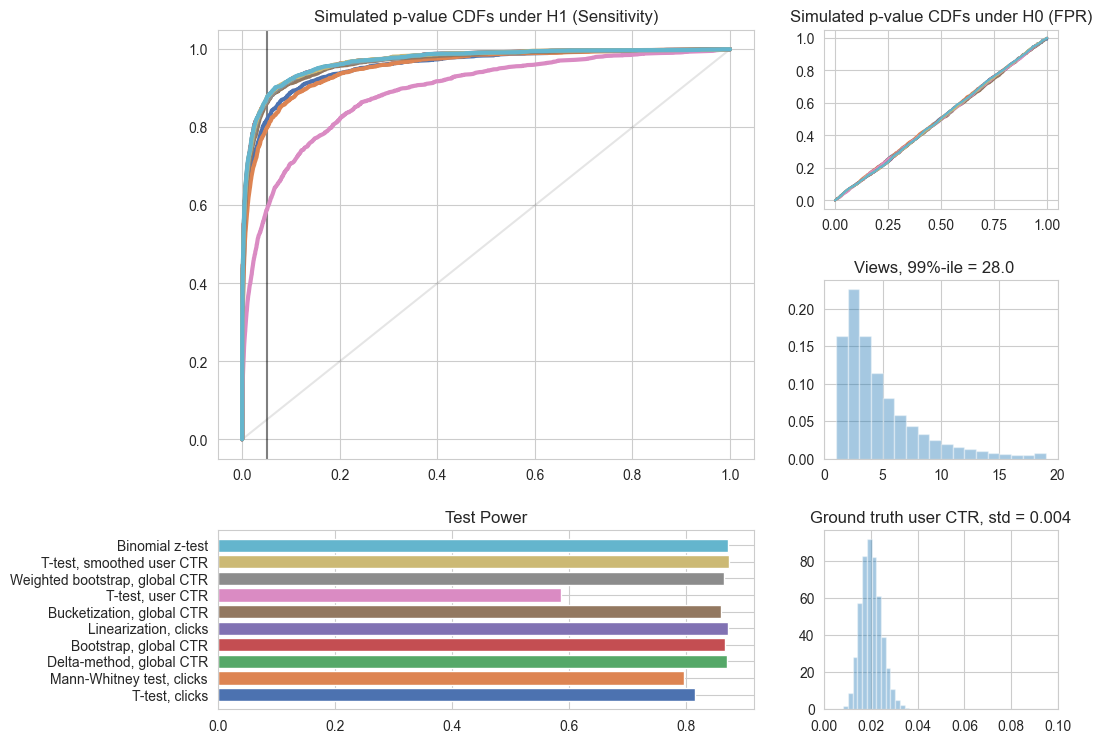

In [5]:
plot_summary(pretty_results, views_0_aa, gt_success_rates)
plt.show()